**B3 Data Analysis**


*Paulo Yoshio Kuga*

In [1]:
#importa todas as bibliotecas   

import pandas as pd
from matplotlib import pyplot as plt
import analysis_lib as al

Dados auxiliares

In [2]:
Referencia = pd.read_excel("leitura.xlsx") #arquivo que ensina a decodificar os csv da b3
Info = pd.read_excel("info.xlsx") #explica os setores das ações

Leitor de dados da B3

In [ ]:
#concatena todos os datasets de ano a ano
firstYear = 2018
lastYear = 2023
Dataset = pd.DataFrame()
for year in range(firstYear,lastYear+1):
    Dataset = pd.concat([Dataset, al.Reader(year)])

In [4]:
#decodifica os arquivos da B3 
CorrectedData = pd.DataFrame()
for tag in Referencia.iterrows():
    ref = tag[1]
    CorrectedData[ref["Nome"]] = Dataset[list(Dataset)[0]].str[ref["Pos In"]-1:ref["Pos Fin"]]
    if ref["Tipo"] == "N":
        CorrectedData[ref["Nome"]] = CorrectedData[ref["Nome"]].astype("Int64")
    elif ref["Tipo"] == "V":
        CorrectedData[ref["Nome"]] = CorrectedData[ref["Nome"]].astype("Float64")/100
    else:
        CorrectedData[ref["Nome"]] = CorrectedData[ref["Nome"]].str.strip()

#ajusta a data para sendo uma data mesmo
CorrectedData["DATA"] = CorrectedData["DATA"].astype(str) #ele entende como numero

#adapta a string para data
CorrectedData["DATA"] = pd.to_datetime(CorrectedData["DATA"].str[0:4] + "-" + CorrectedData["DATA"].str[4:6] + "-" + CorrectedData["DATA"].str[6:8]) 

#ajusta e arruma os valores por data e codigo de negociação (teoricamente p/ fazer um sort do array)
CorrectedData.sort_values(by=["CODNEG","DATA"],inplace=True)
CorrectedData.reset_index()       

#exporta para CSV para não precisar fazer o processamento toda vez
CorrectedData.to_csv("correcteddata.csv",index=False) 


In [3]:
#lê o arquivo de dads
CorrectedData = pd.read_csv("correcteddata.csv") 


CorrectedData["DATA"] = pd.to_datetime(CorrectedData["DATA"]) #no csv ele perde o datatype
CorrectedData["Tendencia"] = (CorrectedData["PREABE"]-CorrectedData["PREULT"]).apply(al.Tendencia) #calcula a tendência de cada dia
CorrectedData["Variancia"] = al.Variancia(CorrectedData) #calcula a variância de cada linha

VolTotal = pd.pivot_table(CorrectedData, values="VOLTOT", index="DATA", aggfunc="sum").fillna(0).reset_index() #volume diário
VolTotal = VolTotal.rename(columns={"VOLTOT":"VolDiario"}) #renomeia a coluna
CorrectedData = pd.merge(CorrectedData,  
                    VolTotal,  
                      on ='DATA',  
                      how ='left') #left join para calcular a proporção todo dia

CorrectedData.drop(columns="VolDiario")
CorrectedData["Volume Relativo"] = CorrectedData["VOLTOT"]/CorrectedData["VolDiario"] #calcula o volume relativo

#analisa tendência * propriedade
CorrectedData["TVar"] = (CorrectedData["Tendencia"]*CorrectedData["Variancia"])
CorrectedData["TVol"] = (CorrectedData["Tendencia"]*CorrectedData["VOLTOT"])
CorrectedData["TVolR"] = (CorrectedData["Tendencia"]*CorrectedData["Volume Relativo"])

#analisa o cumulativo do anterior
CorrectedData["CTVar"] = CorrectedData.groupby("CODNEG")["TVar"].cumsum()
CorrectedData["CTVol"] = CorrectedData.groupby("CODNEG")["TVol"].cumsum()
CorrectedData["CTVolR"] = CorrectedData.groupby("CODNEG")["TVolR"].cumsum()

#organiza os dados para ficarem alinhados por ativo e data (ou seja, trechos do dataset ficam organizados como ATIVO-> 2018 a 2023)
CorrectedData = CorrectedData.sort_values(by=["CODNEG","DATA"])


In [14]:
Ativos = CorrectedData["CODNEG"].unique() #lista de todos os ativos negociados

L_acoes = [ativo for ativo in Ativos if len(ativo) <= 5 and int(ativo[4]) >= 3] #lista de acoes
L_fundos = [ativo for ativo in Ativos if len(ativo) <= 6 and ativo[4:6]=='11'] #lista de fundos, ETF's etc
L_BDR = [ativo for ativo in Ativos if len(ativo) <= 6 and ativo[4:6]=='34'] #lista de BDR's

In [29]:
Acoes = CorrectedData[CorrectedData["CODNEG"].isin(L_acoes)].sort_values(by=["CODNEG","DATA"]) #filtra apenas acoes
Acoes = pd.merge(Acoes,Info,on ='CODNEG',how ='left') #importa a classificação por setores
ITSA4_Data = Acoes.loc[Acoes["CODNEG"]=="ITSA4"] #seleciona apenas os dados da ITSA4

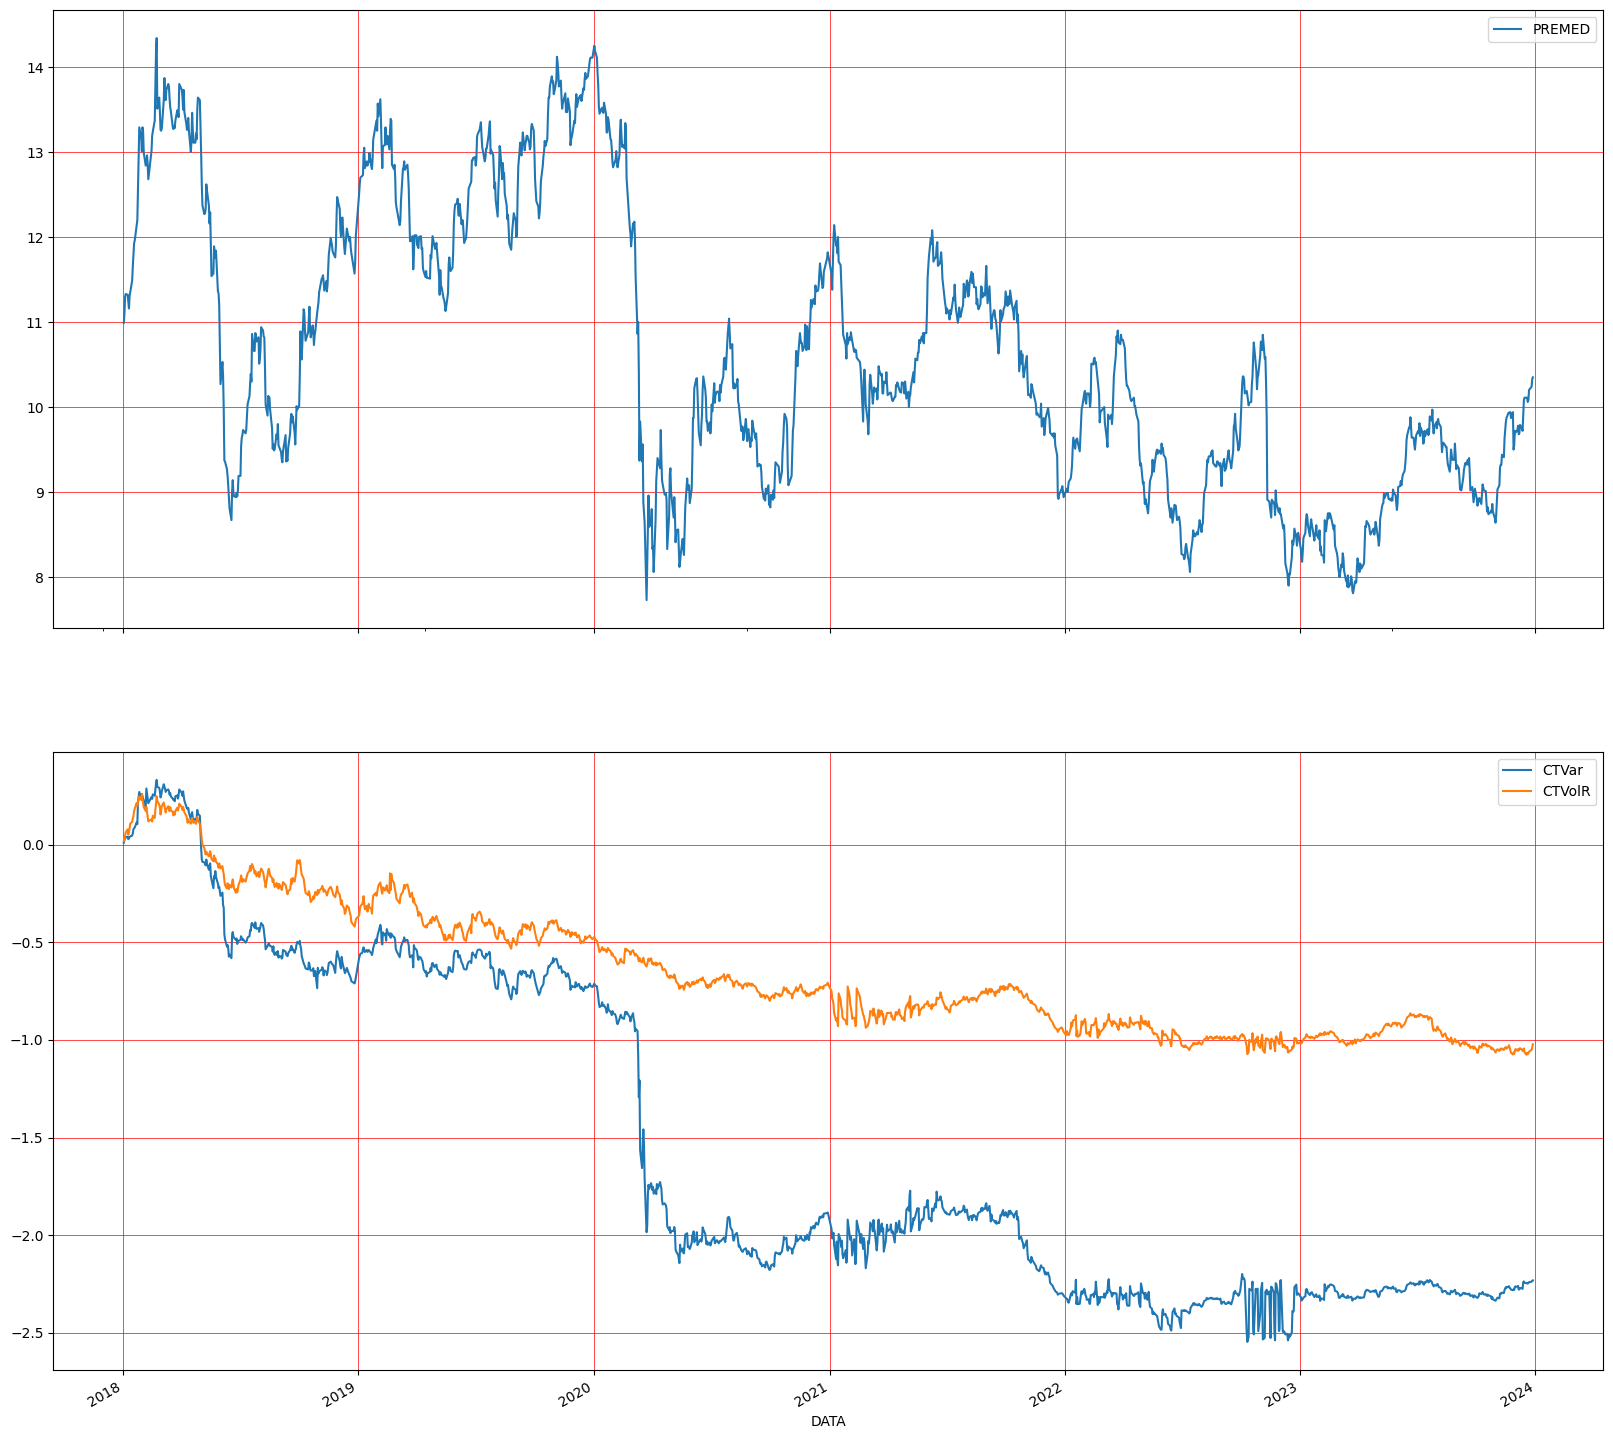

In [30]:
#plota as propriedades 

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,20))
ITSA4_Data.plot(x="DATA",y=["CTVar","CTVolR"], ax=axes[1],sharex=True)
ITSA4_Data.plot(x="DATA",y=["PREMED"],ax=axes[0])
axes[0].grid(color='r', linestyle='-', linewidth=0.5)
axes[1].grid(color='r', linestyle='-', linewidth=0.5)
fig.savefig("ITSA4.png")


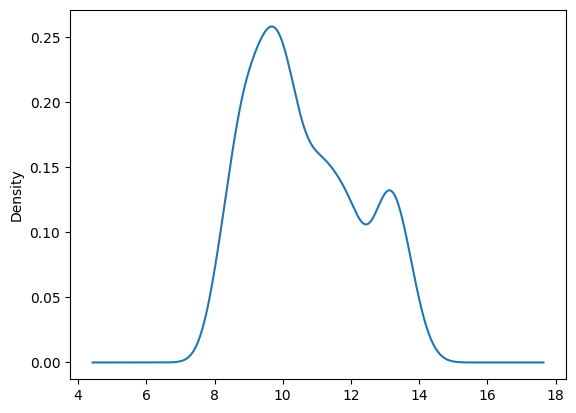

In [31]:
#kernel density estimator 
hist = ITSA4_Data["PREMED"].plot.kde()

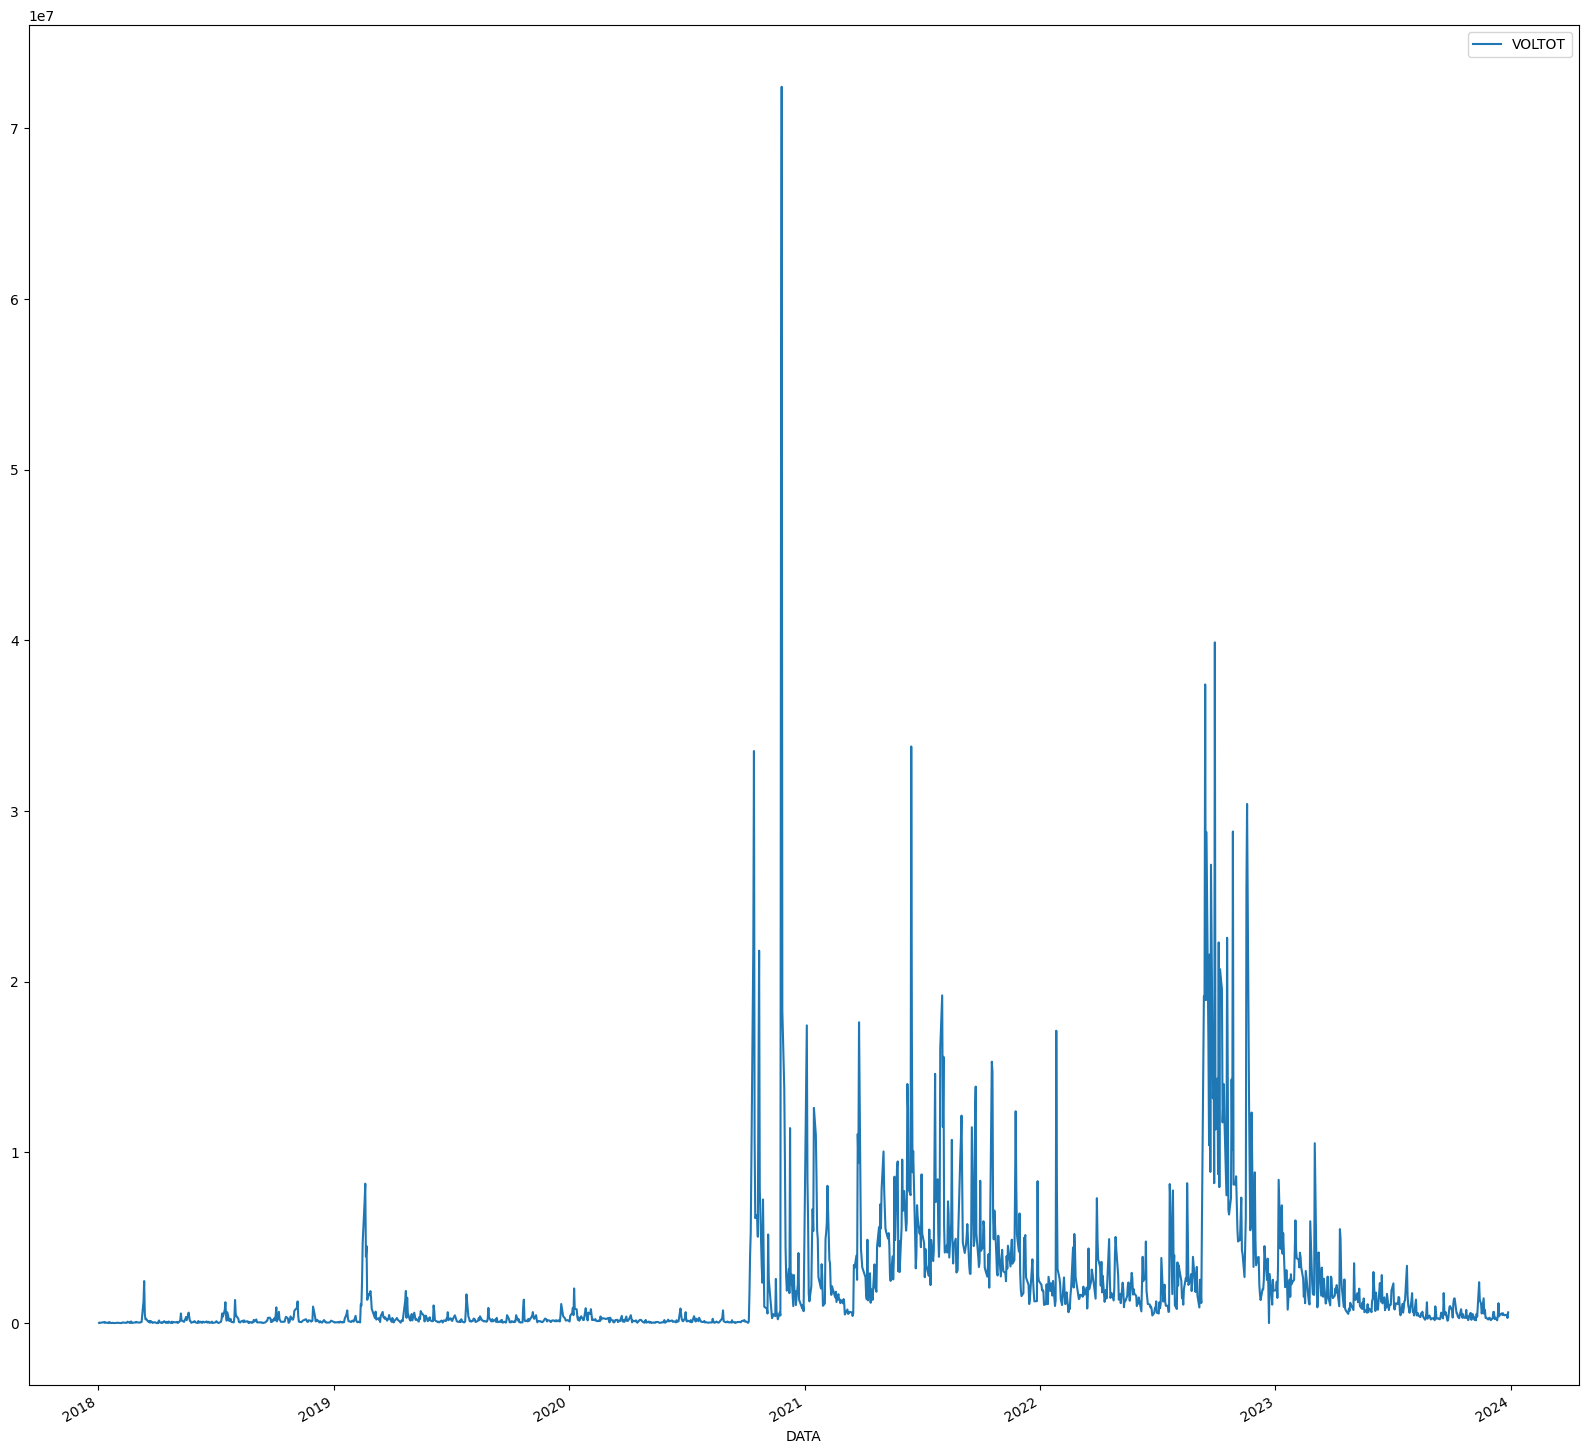

In [11]:
#filtragem por setor -> não é muito relevante, os setores possuem correlação quase que 1

Bancos = Acoes.loc[Acoes["Setor"]=="Banking Services"]
Bancos = pd.pivot_table(Bancos, values=["VOLTOT","PREMED"], index="DATA", aggfunc="sum").fillna(0).reset_index()
Bancos.plot(x="DATA",y=["VOLTOT"],figsize=(20,20))
fig.savefig("Bancos.png")


In [28]:
Setores = pd.pivot_table(Acoes, columns="CODNEG", values="PREMED", index="DATA", aggfunc="sum").fillna(0).reset_index()
Corre = (al.CorrTable(Setores.drop(columns="DATA")))
Corre.to_excel("corre.xlsx")

In [56]:
#analise do IGP-M e DI médios por dia -> reajustar os preços do dataset para a inflação

IGP = pd.read_csv("igp.csv")
IGP.set_index("Data")

IGP["Data"] = pd.to_datetime(IGP["Data"],format="%d/%m/%Y")
IGP = IGP.set_index("Data")
# # # Criar um intervalo de datas contínuo
dr = pd.date_range(start=IGP.index.min(), end=IGP.index.max(), freq='D')

# # # Usar reindex para preencher os valores nos dias ausentes
IGP2 = IGP.reindex(dr, method='ffill')
IGP2
# expanded_series
# # print(expanded_series)

,IGP-P,IGP-DI,Norm
2018-01-01,662826,654968,1.000000
2018-01-02,662826,654968,1.000000
2018-01-03,662826,654968,1.000000
2018-01-04,662826,654968,1.000000
2018-01-05,662826,654968,1.000000
...,...,...,...
2023-10-28,1109236,1092974,1.671134
2023-10-29,1109236,1092974,1.671134
2023-10-30,1109236,1092974,1.671134
2023-10-31,1109236,1092974,1.671134


In [33]:
IGP.index

RangeIndex(start=0, stop=71, step=1)